dict_keys(['All_Beauty', 'Home_and_Kitchen', 'Tools_and_Home_Improvement'])
All_Beauty (5000, 3)
Home_and_Kitchen (5000, 3)
Tools_and_Home_Improvement (5000, 3)
All_Beauty ['rating', 'text', 'title']
Home_and_Kitchen ['rating', 'text', 'title']
Tools_and_Home_Improvement ['rating', 'text', 'title']
All_Beauty
rating
1.0     360
2.0     276
3.0     500
4.0    1000
5.0    2864
Name: count, dtype: int64

Home_and_Kitchen
rating
1.0     257
2.0     140
3.0     355
4.0     709
5.0    3539
Name: count, dtype: int64

Tools_and_Home_Improvement
rating
1.0     291
2.0     180
3.0     314
4.0     848
5.0    3367
Name: count, dtype: int64



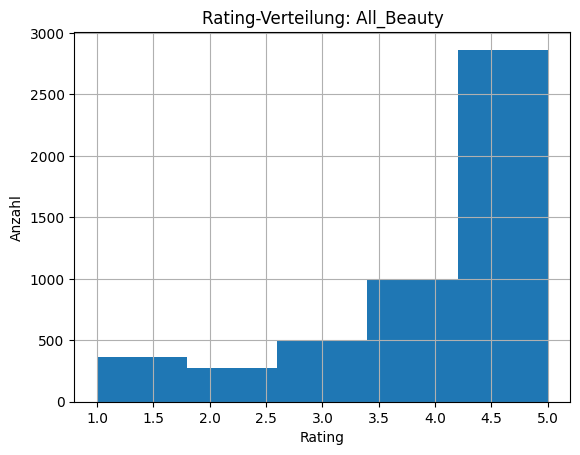

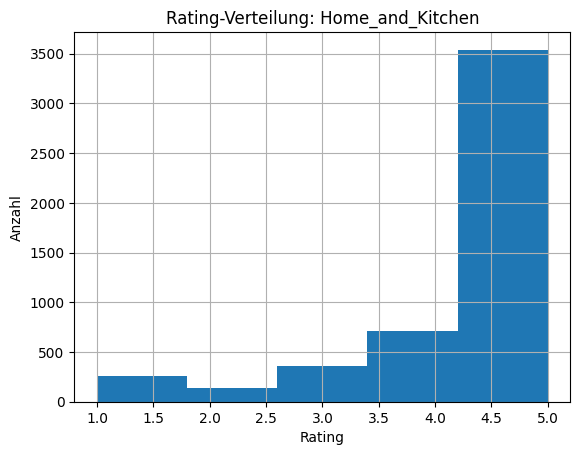

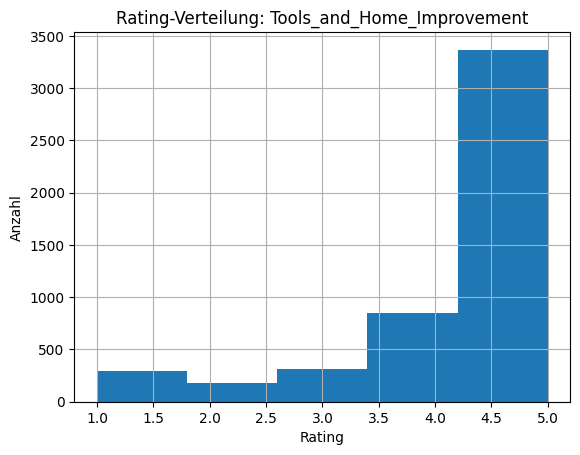

All_Beauty 4.1464
Home_and_Kitchen 4.4266
Tools_and_Home_Improvement 4.364


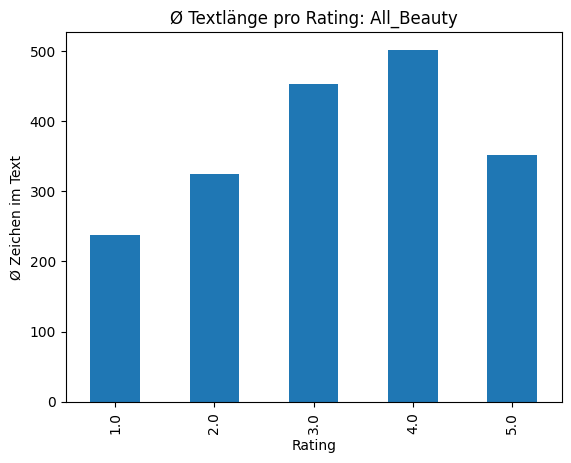

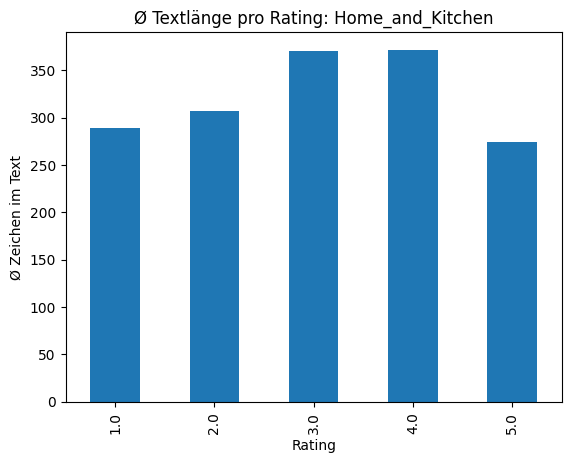

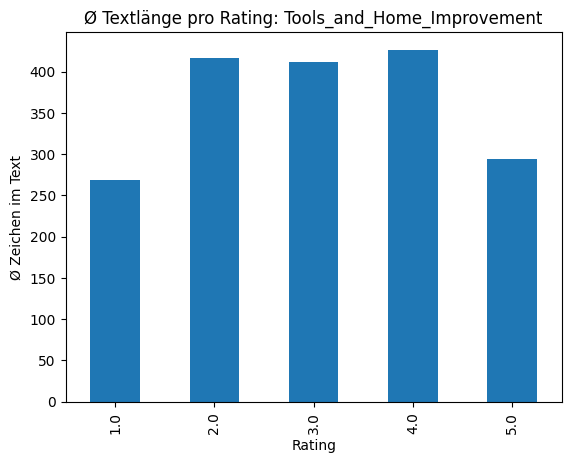

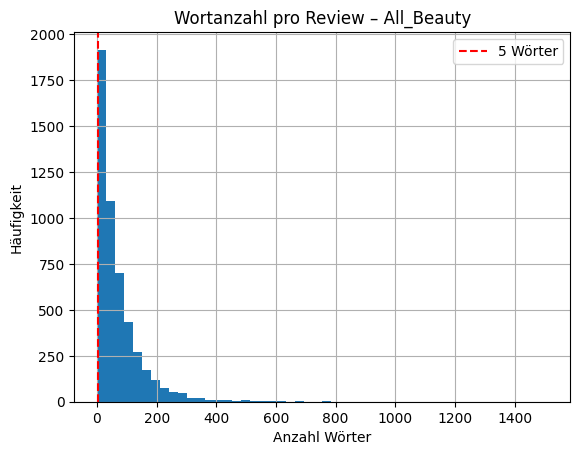

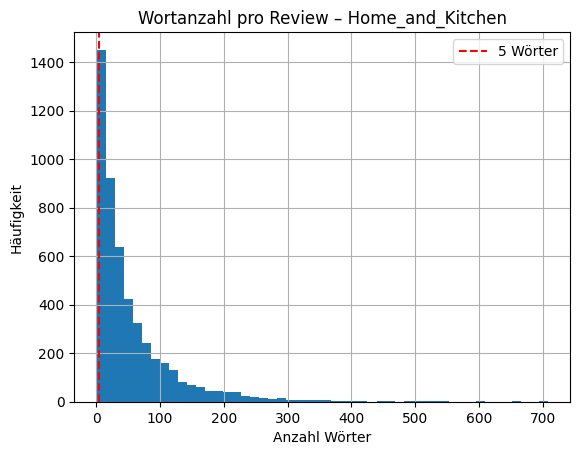

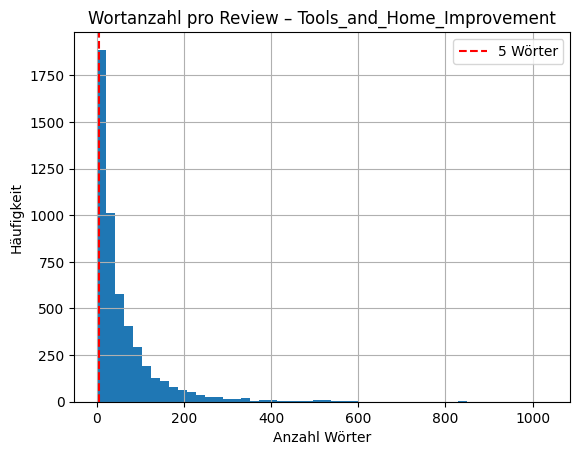

All_Beauty
Gesamt: 5000
Entfernt (<5 Wörter): 336 (6.72%)
Verbleibend: 4664

Home_and_Kitchen
Gesamt: 5000
Entfernt (<5 Wörter): 346 (6.92%)
Verbleibend: 4654

Tools_and_Home_Improvement
Gesamt: 5000
Entfernt (<5 Wörter): 510 (10.20%)
Verbleibend: 4490



In [3]:
%run datenexploration.ipynb

In [8]:
import pandas as pd
import re
df_raw = dfs["All_Beauty"]

"""Überführen von Titel und Text in einen Text. fehlende Werte werden durch Leere Strings ersetzt.
Überflüssige Leerzeichen werden entfernt"""
def build_full_text(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["title"] = df["title"].fillna("")
    df["text"] = df["text"].fillna("")
    df["full_text"] = (df["title"].str.strip() + " " + df["text"].str.strip()).str.strip()
    return df
df_clean = build_full_text(df_raw)
df_clean["full_text"].head(5)

0    Such a lovely scent but not overpowering. This...
1    Works great but smells a little weird. This pr...
2                       Yes! Smells good, feels great!
3                     Synthetic feeling Felt synthetic
4                                           A+ Love it
Name: full_text, dtype: object

In [9]:
_non_alpha = re.compile(r"[^a-zA-Z\s]+")

def clean_text_series(s: pd.Series) -> pd.Series:
    """Alles klein schreiben, Sonderzeichen durch Leerzeichen ersetzen und
    mehrere Leerzeichen zu einem machen"""
    s = s.str.lower()
    s = s.str.replace(_non_alpha, " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s

pattern = re.compile(r"[^a-z\s]")
df_clean["full_text"].str.contains(pattern).any()


np.True_

In [19]:
def add_word_count(df: pd.DataFrame, text_col: str = "full_text") -> pd.DataFrame:
    """Spaltet den Text in Wörter und zählt sie"""
    df = df.copy()
    df["word_count"] = df[text_col].fillna("").str.split().str.len()
    return df

def filter_short_reviews(df: pd.DataFrame, min_words: int = 5, text_col: str = "full_text") -> pd.DataFrame:
    """Entfernen von Reviews mit wenigre als 5 Wörtern"""
    df = add_word_count(df, text_col=text_col)
    return df[df["word_count"] >= min_words].copy()

(df_clean["word_count"] < 5).sum()

np.int64(0)

In [20]:
def preprocess_df(df: pd.DataFrame, min_words: int = 5) -> pd.DataFrame:
    """Neuen Dataframe mit vorverarbeiteten Daten erstellen"""
    df = build_full_text(df)
    df = df.copy()
    df["full_text"] = clean_text_series(df["full_text"])
    df = filter_short_reviews(df, min_words=min_words, text_col="full_text")
    # rating als int (falls nötig)
    df["rating"] = df["rating"].astype(int)
    return df

In [21]:
dfs_clean = {}
for cat, df in dfs.items():
    """Auf alle Kategorien anwenden und Kontrolle"""
    before = len(df)
    df_clean = preprocess_df(df, min_words=5)
    after = len(df_clean)
    print(f"{cat}: vorher={before}, nachher={after}, entfernt={before-after} ({(before-after)/before*100:.2f}%)")
    dfs_clean[cat] = df_clean

All_Beauty: vorher=5000, nachher=4850, entfernt=150 (3.00%)
Home_and_Kitchen: vorher=5000, nachher=4871, entfernt=129 (2.58%)
Tools_and_Home_Improvement: vorher=5000, nachher=4671, entfernt=329 (6.58%)


In [22]:
cat = "All_Beauty"

df_raw = dfs[cat]
df_clean = dfs_clean[cat]

i = 27 # irgendein Index
print("ORIGINAL:")
print(df_raw.loc[i, ["title", "text"]])

print("\nBEREINIGT:")
print(df_clean.loc[i, "full_text"])

ORIGINAL:
title                             not what it claims to do
text     nothing special  unfortunately i waited too lo...
Name: 27, dtype: object

BEREINIGT:
not what it claims to do nothing special unfortunately i waited too long to return them no results at all dont waste your money


In [14]:
df_clean.dtypes

rating         int64
text          object
title         object
text_len       int64
word_count     int64
full_text     object
dtype: object

In [15]:
df_all = pd.concat(dfs_clean.values(), ignore_index=True)

print(len(df_all))

X = df_all["full_text"]
y = df_all["rating"]

from sklearn.model_selection import train_test_split
"""X=Features, Y=Labels, test_size=0.2-> 20% der Daten sind Testdaten,
stratify=y -> löst das Problem des Klassenungleichgewichts,
random_state=42 -> Garantiert selben Startwert bei jedem Lauf"""
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

14392


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
"""Bigrams ermöglichen training von Wortpaaren mit z.B. Negationen; max. features begrenzt das Vokabular um Rechenleistung zu minimieren; ein Wortpaar wird nur dann als feature aufgenommen wenn es in mindestens 5 Bewertungen vorkommt; englische Stoppwörter werden entfernt"""
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10_000,
    min_df=5,
    stop_words="english"
)

In [17]:
X_train_tfidf = tfidf.fit_transform(X_train)  # lernt Vokabular + erstellt Matrix
X_test_tfidf  = tfidf.transform(X_test)       # nutzt gleiches Vokabular

In [23]:
"""Zeigt Anzahl der Reviews die für das Training genutzt wurden und die Anzahl der Features."""
print(X_train_tfidf.shape)

(11513, 10000)
